<a href="https://colab.research.google.com/github/orekhovsky/ITMO_Masters/blob/main/Introduction%20%26%20Advanced%20ML/kNN%20%2B%20Naive%20Bayes/KNN_Students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 task

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import seaborn as sns
from matplotlib import pyplot as plt

In [9]:
df = pd.read_csv('1 task.txt')
df.set_index('id')

,X,Y,Class
id,,,
1,96,95,0
2,15,17,0
3,85,76,0
4,70,37,0
5,64,64,0
6,62,24,1
7,48,45,1
8,75,99,1
9,95,58,0


In [10]:
X_train = df.loc[:,['X', 'Y']]
y_train = df.loc[:,'Class']
X_pred = pd.DataFrame({'X': [39], 'Y': [22]})

In [11]:
print("Euclidean metric results:")
knn_clfr = KNeighborsClassifier(n_neighbors=3, p=2)
knn_clfr.fit(X_train,y_train)
ans = knn_clfr.kneighbors(X_pred, n_neighbors=3)
print("min distance: ", ans[0][0][0])
print("3 nearest obj:", ans[1][0])
y_pred = knn_clfr.predict(X_pred)
print(f'class: {y_pred[0]}')

Euclidean metric results:
min distance:  16.278820596099706
3 nearest obj: [9 5 1]
class: 0


In [12]:
print("Manhattan metric results:")
knn_clfr = KNeighborsClassifier(n_neighbors=3, p=1)
knn_clfr.fit(X_train,y_train)
ans = knn_clfr.kneighbors(X_pred, n_neighbors=3)
print("min distance: ", ans[0][0][0])
print("3 nearest obj:", ans[1][0])
y_pred = knn_clfr.predict(X_pred)
print(f'class: {y_pred[0]}')

Manhattan metric results:
min distance:  23.0
3 nearest obj: [9 5 1]
class: 0


# 0. Применение метода KNN для решения задачи классификации

Набор данных получен в результате переписи населения 1994 года и содержит информацию о некотором количестве людей, проживающих в США. Задача состоит в том, чтобы предсказать, зарабатывает человек более $50к в год или нет. Список признаков:

*   <b>age</b>: возраст человека.
*   <b>workclass</b>: статус занятости.
*   <b>fnlwgt</b>: количество людей, которое, по мнению переписи, представляет запись.
*   <b>education</b>: высший уровень образования, достигнутый человеком.
*   <b>education-num</b>: высший уровень образования, достигнутый человеком в числовой форме.
*   <b>marital-status</b>: семейное положение человека.
*   <b>occupation</b>: общий род занятий человека.
*   <b>relationship</b>: представляет то, чем этот человек является по отношению к другим (перекликается с признаком <b>marital-status</b>).
*   <b>race</b>: раса.
*   <b>sex</b>: пол.
*   <b>capital-gain</b>: прирост капитала.
*   <b>capital-loss</b>: убыток капитала.
*   <b>hours-per-week</b>: число рабочих часов в неделю.
*   <b>native-country</b>: страна происхождения.
*   <b>the label</b>: отклик -- зарабатывает больше $50к или меньше.



## Немного про метрики качества модели

Для начала рассмотрим так называемую матрицу ошибок (confusion matrix)
-- способ разделить объекты на $4$ группы в зависимости от комбинации
истинного класса и ответа классификатора:

-   TP (True Positives) -- верно классифицированные объекты, исходно     относящиеся к классу "$+1$";

-   TN (True Negatives) -- верно классифицированные объекты, исходно     относящиеся к классу "$-1$";

-   FN (False Negatives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$+1$" (ошибка I рода);

-   FP (False Positives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$-1$" (ошибка II рода).

Обычно, конечно, оперируют не абсолютными показателями, а относительными
-- долями (rates), находящимися в диапазоне от $0$ до $1$:

-   доля правильных ответов классификатора (иногда -- точность): $$\mathsf{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN}.$$ Эта величина показывает отношение количества верно классифицированных объектов к общему количеству классифицируемых объектов и, грубо говоря, оценивает вероятность случайному объекту быть правильно классифицированным.

-   доля истинно положительных примеров -- True Positives Rate (TPR) или     Sensitivity (чувствительность) или Recall: $$\mathsf{T P R}=\frac{T P}{T P+F N}.$$ Эта величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$+1$", к общему количеству объектов класса "$+1$". Иными словами -- это оценка вероятности, что объект, относящийся к классу "$+1$" будет классифицирован корректно.

-   доля ложно положительных примеров обозначается как -- False Positives Rate (FPR): $$\mathsf{F P R}=\frac{F P}{FP + TN}.$$ Величина показывает отношение количества неверно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован неверно.

-   Специфичность (Specificity) или True Negatives Rate (TNR): $$\mathsf{TNR} = 1 - \mathsf{F P R} =\frac{T N}{T N+F P}.$$ Величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован верно.

-   Precision (точность): $$\mathsf{Precision} =\frac{TP}{TP + FP}.$$ Величина показывает, какая доля объектов, отнесенных классификатором к классу "$+1$", действительно относится к этому классу.

Естественно возникает вопрос, нет ли какого-то обобщающего критерия,
который может характеризовать качество построенной модели. Один из них --
так называемая $F$-мера ($F_1$-мера, $F$ score, $F_1$ score)
определяется следующим соотношением:
$$F = F_1 = 2 \cdot \frac{\mathsf{Precision} \cdot \mathsf{Recall}}{\mathsf{Precision} + \mathsf{Recall}}.$$

**Замечание**. *$F$-мера является средним гармоническим величин
$\mathsf{Precision}$ и $\mathsf{Recall}$ и заключена в диапазоне
$[0, 1]$. Среднее гармоническое обладает важным свойством: оно близко к
нулю, если хотя бы один из аргументов близок к нулю. Поэтому оно является
куда более предпочтительным, чем, скажем, среднее арифметическое: если
алгоритм относит все объекты к положительному классу, то
$\mathsf{Recall}= 1$, а $\mathsf{Precision}$, скорее всего, будет
небольшим. Но тогда среднее арифметическое будет больше, чем $0.5$, что,
конечно, никуда не годится.*

## Импорт библиотек и чтение набора данных

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import seaborn as sns
from matplotlib import pyplot as plt

Считайте набор данных в датафрейм. Исходя из описания признаков можно сразу избавиться от признаков <code>education</code> и <code>marital-status</code>. Удалите соответствующие колонки из набора данных.

In [40]:
df = pd.read_csv('adult_data_train.csv', na_values={'?'})
df = df.drop(columns=['education', 'marital-status'])
df.head()

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,NaN,122244,9,NaN,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0


Определите количество числовых и нечисловых признаков.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26048 entries, 0 to 26047
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             26048 non-null  int64 
 1   workclass       24575 non-null  object
 2   fnlwgt          26048 non-null  int64 
 3   education-num   26048 non-null  int64 
 4   occupation      24569 non-null  object
 5   relationship    26048 non-null  object
 6   race            26048 non-null  object
 7   sex             26048 non-null  object
 8   capital-gain    26048 non-null  int64 
 9   capital-loss    26048 non-null  int64 
 10  hours-per-week  26048 non-null  int64 
 11  native-country  25590 non-null  object
 12  label           26048 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 2.6+ MB


In [41]:
numeric_cols = df.select_dtypes(include='number').columns
num_numeric_cols = len(numeric_cols) - 1 # -1, т.к. label это не признак
print(f"Числовые признаки: {num_numeric_cols}")

non_numeric_cols = df.select_dtypes(exclude='number').columns
num_non_numeric_cols = len(non_numeric_cols)
print(f"Нечисловые признаки: {num_non_numeric_cols}")

Числовые признаки: 6
Нечисловые признаки: 6


Постройте гистограмму распределения объектов по классам. Вычислите долю объектов класса $0$.

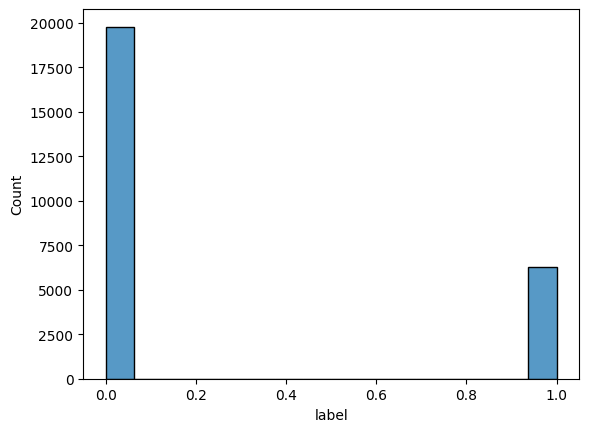

0.7591753685503686

In [42]:
sns.histplot(df['label'])
plt.show()

counts = df['label'].value_counts()
counts[0]/(counts[0]+counts[1])

# 1. Построение базовой модели

В качестве первого приближения имеет смысл построить модель классификации, опираясь исключительно на числовые признаки.

Отберите из набора данных только числовые признаки. При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки <b>с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>label</code>.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных.

Обучите модель <code>KNeighborsClassifier()</code> с параметрами по умолчанию на тренировочных данных.

Как видно из предыдущего пункта, в наборе данных наблюдается явный дисбаланс представителей классов. Это следует учесть при оценке модели. Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.

В качестве альтернативы можно использовать так называемый <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html"><code>classification_report()</code></a>, где приведены сразу несколько метрик (не стоит забывать про параметр <code>digits</code>).

In [43]:
df1 = df[numeric_cols]
X_train1, X_test1, y_train1, y_test1 = train_test_split(df1.drop(columns=['label']), df1['label'], test_size=0.2, random_state=7, stratify=df1['label'])

In [44]:
# выборочное среднее
np.mean(X_train1['fnlwgt'])

189789.851281313

In [45]:
neigh = KNeighborsClassifier()
neigh.fit(X_train1, y_train1)
# f1 скор на параметрах по умолчанию
f1_score(y_test1, neigh.predict(X_test1))

0.38031088082901554

Стоит помнить, что KNN является метрическим классификатором, поэтому значения признаков перед обучением модели следует нормировать.

Обучите преобразование <code>MinMaxScaler()</code> на тренировочном наборе данных и примените его для тренировочных и тестовых данных.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных после нормировки.

Заново обучите и оцените модель на преобразованных данных. Вычислите <code>f1_score()</code> модели.

In [46]:
scaler = MinMaxScaler()
X_train1_scaled = pd.DataFrame(scaler.fit_transform(X_train1), columns=X_train1.columns, index=X_train1.index)
X_test1_scaled = pd.DataFrame(scaler.transform(X_test1), columns=X_test1.columns, index=X_test1.index)

In [47]:
np.mean(X_train1_scaled['fnlwgt'])

0.12055313788274608

In [48]:
neigh = KNeighborsClassifier()
neigh.fit(X_train1_scaled, y_train1)
# f1 скор на параметрах по умолчанию
f1_score(y_test1, neigh.predict(X_test1_scaled))

0.5160390516039052

Видно, что после линейной нормировки качество выросло.

<b>Важно: </b>На дальнейших этапах подразумевается использование линейной нормировки непосредственно перед обучением без дополнительных напоминаний.

# 2. Работа с нечисловыми признаками

## Визуализация

Для дальнейшего улучшения качества модели имеет смысл задействовать нечисловые признаки исходного датасета (без колонок <code>education</code> и <code>marital-status</code>).

Постройте гистограммы, иллюстрирующие частоту того или иного значения по каждому нечисловому признаку, например, при помощи <code>sns.barplot()</code>.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['label']), df['label'], test_size=0.2,
                                                        random_state=7, stratify=df['label'])

In [50]:
non_numeric_cols = df.select_dtypes(exclude='number').columns
X_train[non_numeric_cols]

,workclass,occupation,relationship,race,sex,native-country
3862,Private,Sales,Unmarried,White,Male,United-States
5639,Local-gov,Other-service,Not-in-family,White,Male,United-States
23174,Private,Handlers-cleaners,Not-in-family,Black,Male,United-States
21536,Private,Priv-house-serv,Other-relative,White,Female,United-States
4545,Private,Adm-clerical,Unmarried,White,Female,United-States
...,...,...,...,...,...,...
1235,NaN,NaN,Own-child,White,Male,United-States
13454,Self-emp-not-inc,Sales,Husband,White,Male,United-States
24659,Private,Other-service,Unmarried,White,Female,United-States
13670,Federal-gov,Prof-specialty,Husband,White,Male,United-States


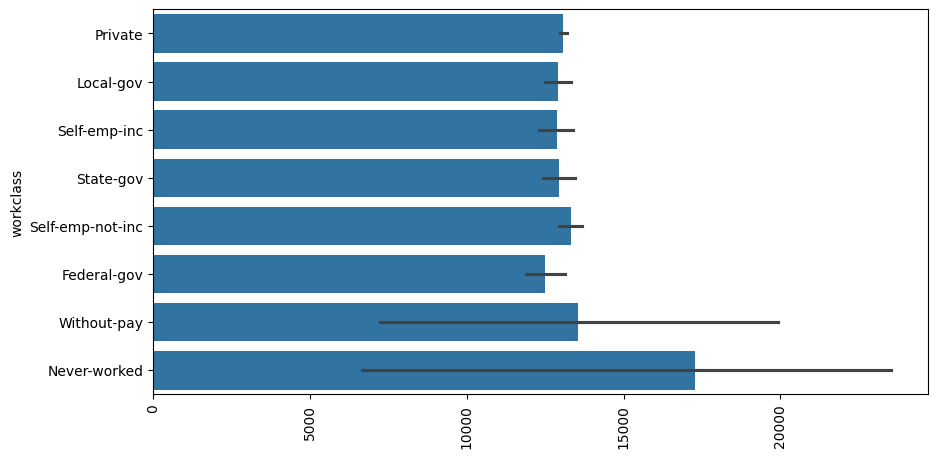

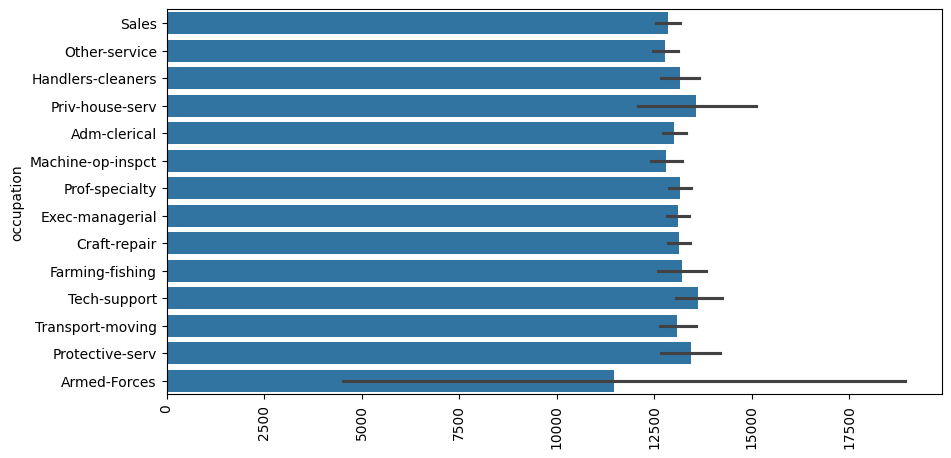

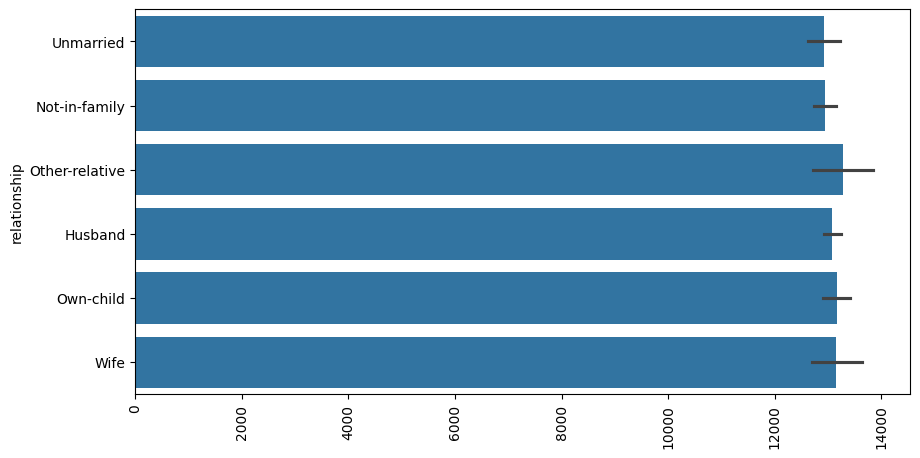

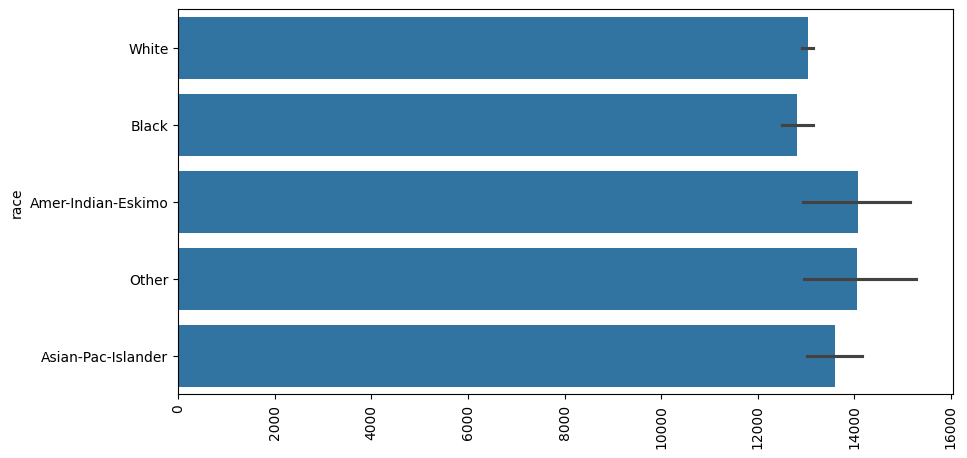

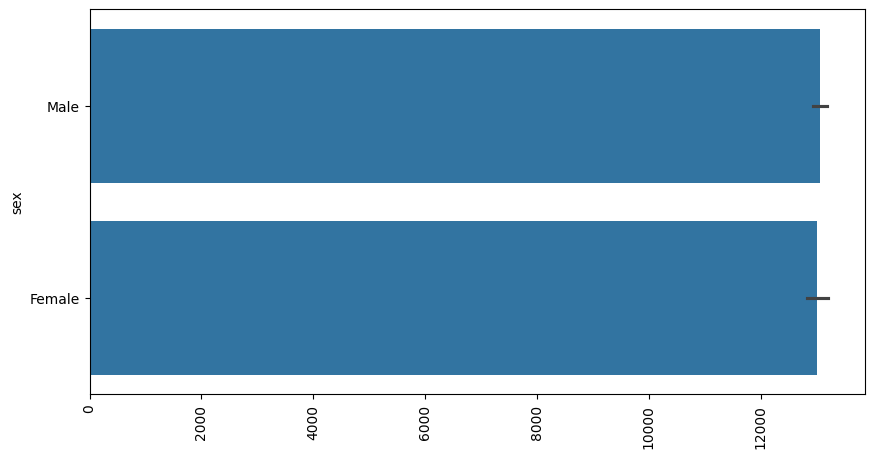

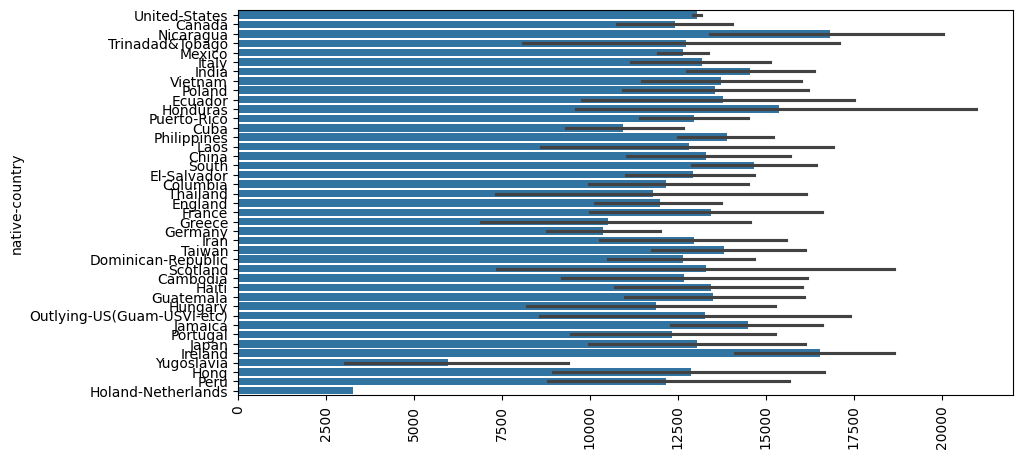

In [54]:
for col in non_numeric_cols:
    fig = plt.figure(figsize=(10, 5))
    ax = sns.barplot(X_train[col])
    plt.xticks(rotation=90)

## Удаление пропущенных значений

Определите число строк исходного набора данных (без колонок <code>education</code> и <code>marital-status</code>), в которых присутствует хотя бы одно пропущенное значение.

In [30]:
len(df[df.isna().any(axis=1)])

1914

In [31]:
df1 = df.dropna()

Видно, что в датасете содержится менее 10% строк, содержащих пропуски. Выкидывать такое количество строк — не очень хорошее дело, но почему бы не попробовать обойтись без них.

Удалите строки, содеражащие пропуски. Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>.

Введите число полученных признаков.

In [32]:
df1 = pd.get_dummies(df1, drop_first=True)
len(df1.columns)-1

75

Обучите модель классификации аналогично тому, как это было проделано для базовой модели. Вычислите <code>f1_score()</code> модели.



In [34]:
X_train, X_test, y_train, y_test = train_test_split(df1.drop(columns=['label']), df1['label'], test_size=0.2,
                                                        random_state=7, stratify=df1['label'])

In [35]:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [36]:
neigh = KNeighborsClassifier()
neigh.fit(X_train_scaled, y_train)
# f1 скор на параметрах по умолчанию
f1_score(y_test, neigh.predict(X_test_scaled))

0.6206896551724138

Точность модели увеличилась по сравнению с моделью, которая использовала только числовые признаки.

## Заполнение пропущенных значений

Возможно точность еще повысится, если задействовать строки с пропущенными значениями. Используя исходный датасет (без колонок <code>education</code> и <code>marital-status</code>), заполните пропуски самым часто встречающимся значением в рамках столбца.

In [37]:
columns_with_na = ['workclass', 'occupation', 'native-country']
for col in columns_with_na:
    most_frequent_value = df[col].mode()[0]
    df[col].fillna(most_frequent_value, inplace=True)

<ipython-input-37-23e80af13586>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(most_frequent_value, inplace=True)


Далее по уже знакомому сценарию: <code>one-hot</code>, <code>split</code>, <code>scaling</code>, обучение и оценка.

Вычислите <code>f1_score()</code> модели.

In [39]:
df = pd.get_dummies(df, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['label']), df['label'], test_size=0.2,
                                                        random_state=7, stratify=df['label'])
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

neigh = KNeighborsClassifier()
neigh.fit(X_train_scaled, y_train)
# f1 скор на параметрах по умолчанию
f1_score(y_test, neigh.predict(X_test_scaled))

0.6098692534795445

## Проклятие размерности

В последнем пункте был получен набор данных, содержащий 76 признаков (кстати, попробуйте объяснить, почему в случае удаления строк число признаков в итоге оказалось равным 75), что является достаточным для того, чтобы столкнуться с так называемым проклятием размерности.

Для того, чтобы классификатор давал более качественные результаты, имеет смысл более внимательно и вдумчиво поработать с признаками с учетом проклятия размерности. Например, вернуть в рассмотрение признаки <code>education-num</code> и <code>marital-status</code>. А также более глубоко вникнуть в саму природу признаков.

# 3 task

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import seaborn as sns
from matplotlib import pyplot as plt

In [57]:
df_train = pd.read_csv('adult_data_train.csv', na_values={'?'})
X_test = pd.read_csv('adult_data_reserved.csv', na_values={'?'})
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,32,Private,37210,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
1,43,Private,101950,Masters,14,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
2,20,NaN,122244,HS-grad,9,Never-married,NaN,Not-in-family,White,Female,0,0,28,United-States,0
3,40,Local-gov,24763,Some-college,10,Divorced,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
4,24,Private,113936,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0


In [58]:
columns_with_na = ['workclass', 'occupation', 'native-country']
for col in columns_with_na:
    most_frequent_value = df_train[col].mode()[0]
    df_train[col].fillna(most_frequent_value, inplace=True)
    X_test[col].fillna(most_frequent_value, inplace=True)

<ipython-input-58-c78646d484ce>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[col].fillna(most_frequent_value, inplace=True)
<ipython-input-58-c78646d484ce>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

In [59]:
X_train = df_train.drop(columns=['label'])
y_train = df_train['label']

In [60]:
df_all = pd.concat([X_train, X_test])
non_numeric_cols = df_all.select_dtypes(exclude='number').columns

for col in non_numeric_cols:
    le = LabelEncoder()
    df_all[col] = le.fit_transform(df_all[col])

X_train = df_all.iloc[:len(X_train)]
X_test = df_all.iloc[len(X_train):]

In [61]:
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

X_tr, X_te, y_tr, y_te = train_test_split(X_train_scaled, y_train, test_size=0.1,
                                                        random_state=41, stratify=y_train)


In [62]:
for num in range(5,20):
    neigh = KNeighborsClassifier(n_neighbors=num, weights='distance')
    neigh.fit(X_tr, y_tr)
    # f1 скор на параметрах по умолчанию
    print(num, f1_score(y_te, neigh.predict(X_te)) )

5 0.6243567753001715
6 0.6317596566523606
7 0.631762652705061
8 0.6369982547993019
9 0.6373239436619719
10 0.6385224274406333
11 0.6306465899025686
12 0.6317657497781721
13 0.6225402504472272
14 0.6225402504472272
15 0.6218637992831542
16 0.6272401433691757
17 0.6182795698924731
18 0.6264626462646264
19 0.6229802513464991


In [63]:
neigh = KNeighborsClassifier(n_neighbors=10, weights='distance')
neigh.fit(X_train_scaled, y_train)
# f1 скор на параметрах по умолчанию
f1_score(y_train, neigh.predict(X_train_scaled))

0.999920286966919

In [64]:
ans = list(neigh.predict(X_test_scaled))

In [65]:
print(ans)

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 